# Use Case 9: Survival Analysis of Endometrial Cancer--PODXL, RAC2, and Tumor Stage

Through modern statistical methods, we can determine survival risk based on a variety of factors.  In this tutorial, we will walk through a small example of something you could do with our data to understand what factors relate with survival in various different types of cancer.  In this use case, we will be looking at Endometrial Cancer.

## Step 1: Import Data and Dependencies

In [1]:
import pandas as pd
import cptac
import cptac.utils as ut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
en = cptac.Ucec()
clinical = en.get_clinical('mssm')
proteomics = en.get_proteomics('umich')
follow_up = en.get_followup('mssm')

cptac warning: Your version of cptac (1.5.1) is out-of-date. Latest is 1.5.0. Please run 'pip install --upgrade cptac' to update it. (C:\Users\sabme\anaconda3\lib\threading.py, line 910)


## Step 2: Gather Data from CPTAC API
The Endometrial cancer dataset contains months of follow-up data, including whether a patient is still alive (Survival Status) at each follow-up period.  We will first merge the clinical and follow-up tables together for analysis. Then we will choose a few attributes to focus on, and narrow our dataframe to those attributes. While you could study a wide variety of factors related to survival, we will be focusing on tumor stage, grade and a proteins of interest listed below in *omics_genes*.

First we will join the *clinical* and *proteomics* dataframes to contain protein data for proteins of interest, and clinical data for each patient in the same dataframe.

In [3]:
cols = list(clinical.columns)
omics_genes = ['RAC2', 'PODXL']

clinical_and_protein = en.join_metadata_to_omics(metadata_name="clinical",
                                                 metadata_source="mssm",
                                                 metadata_cols=cols,
                                                 omics_name="proteomics",
                                                 omics_source="umich",
                                                 omics_genes=omics_genes)

Next, we will rename the foreign key ("PPID" -> "Patient_ID") on the follow_up table to allow us to easily join that data with the dataframe of clinical and protein data

In [4]:
follow_up = follow_up.rename({'PPID' : 'Patient_ID'}, axis='columns')
clin_prot_follow = pd.merge(clinical_and_protein, follow_up, on = "Patient_ID")
clinical_and_protein

Name,tumor_code,discovery_study,type_of_analyzed_samples_mssm_clinical,type_of_analyzed_samples_mssm_clinical,confirmatory_study,age,sex,race,ethnicity,ethnicity_race_ancestry_identified,...,number_of_days_from_date_of_initial_pathologic_diagnosis_to_date_of_additional_surgery_for_new_tumor_event_loco-regional,number_of_days_from_date_of_initial_pathologic_diagnosis_to_date_of_additional_surgery_for_new_tumor_event_metastasis,"Recurrence-free survival, days","Recurrence-free survival from collection, days","Recurrence status (1, yes; 0, no)","Overall survival, days","Overall survival from collection, days","Survival status (1, dead; 0, alive)",RAC2_umich_proteomics,PODXL_umich_proteomics
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,UCEC,Yes,Tumor_and_Normal,NaN,NaN,64,Female,White,Not Hispanic or Latino,White,...,NaN,NaN,NaN,NaN,0.0,737.0,737.0,0.0,-0.182830,0.731055
C3L-00008,UCEC,Yes,Tumor,NaN,NaN,58,Female,White,Not Hispanic or Latino,White,...,NaN,NaN,NaN,NaN,0.0,898.0,898.0,0.0,-0.793159,0.451984
C3L-00032,UCEC,Yes,Tumor,NaN,NaN,50,Female,White,Not Hispanic or Latino,White,...,NaN,NaN,NaN,NaN,0.0,1710.0,1710.0,0.0,0.583774,1.344697
C3L-00084,UCEC,Yes,Tumor,NaN,NaN,74,Female,White,Not Hispanic or Latino,White,...,NaN,NaN,NaN,NaN,0.0,335.0,335.0,0.0,-0.193889,-1.994844
C3L-00090,UCEC,Yes,Tumor,NaN,NaN,75,Female,White,Not Hispanic or Latino,White,...,NaN,NaN,50.0,56.0,1.0,1281.0,1287.0,1.0,-0.361299,0.154995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NX5.N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.864272,-0.980967
NX6.N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.841041,-0.260866
NX7.N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.430521,-0.498802


In [5]:
#Determine columns to focus on, and create a subset to work with
columns_to_focus_on = ['Survival status (1, dead; 0, alive)',
                       'number_of_days_from_date_of_collection_to_date_of_last_contact', 
                       'number_of_days_from_date_of_collection_to_date_of_death',
                       'tumor_stage_pathological']

#This adds the protein data that we got from the clinical and proteomics join
#so that it will be present in our subset of data to work with
for i in range(len(omics_genes)):
    omics_genes[i] += '_umich_proteomics'
    columns_to_focus_on.append(omics_genes[i])

focus_group = clin_prot_follow[columns_to_focus_on].copy().drop_duplicates()

## Step 3: Kaplan Meier Plotting
Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute(s).  Oftentimes, they are used to plot the probability of death for clinical attributes, however they could also be used in a variety of other contexts. 

We will start by finding all patients that have died during the follow-up period and update the column to contain boolean values, where True denotes that the event occurred ('Deceased'), and False denotes that it did not ('Living').  We will then combine the two columns containing timeframe data ('Days_Between_Collection_And_Last_Contact', and 'Days_Between_Collection_And_Death'), to help us with plotting survival curves. These steps are necessary to fit the requirements of the *lifelines* package.

In [6]:
#Make the Survival Status column boolean
focus_group['Survival status (1, dead; 0, alive)'] = focus_group['Survival status (1, dead; 0, alive)'].replace(0, False)
focus_group['Survival status (1, dead; 0, alive)'] = focus_group['Survival status (1, dead; 0, alive)'].replace(1, True)
focus_group['Survival status (1, dead; 0, alive)'] = focus_group['Survival status (1, dead; 0, alive)'].astype('bool')

In [7]:
cols = ['number_of_days_from_date_of_collection_to_date_of_last_contact', 'number_of_days_from_date_of_collection_to_date_of_death']

focus_group = focus_group.assign(Days_Until_Last_Contact_Or_Death=focus_group[cols].sum(1)).drop(cols, axis=1)

Next, we will create a general Kaplan Meier Plot of overall survival for our cohort, using the KaplanMeierFitter() from the *lifelines* package.

<Axes: xlabel='timeline'>

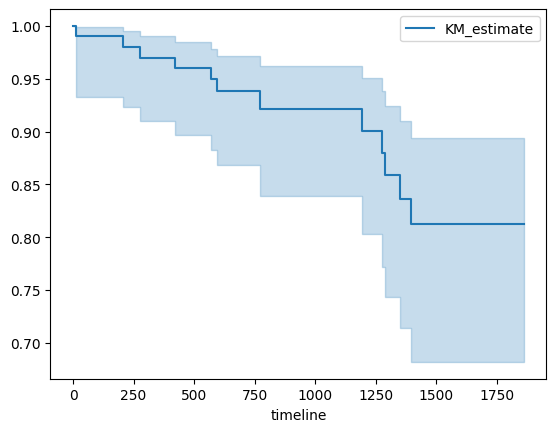

In [8]:
time = focus_group['Days_Until_Last_Contact_Or_Death']
status = focus_group['Survival status (1, dead; 0, alive)']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4 Prepare Data for Multivariate Kaplan Meier Plots and Cox's Proportional Hazard Test
We will now group our columns of interest into 3-4 distinct categories each, and assign them numeric values.  It is necessary for the requirements of the *lifelines* package that the categories are assigned numeric values (other data types, including category, are not compatible with the functions we will be using).

In [9]:
df_genes = focus_group.copy()

#Here, we are separating the protein abundance values for each of our proteins
#of interest into 3 groups, based on relative abundance of the protein
for col in omics_genes:
    lower_25_filter = df_genes[col] <= df_genes[col].quantile(.25)
    upper_25_filter = df_genes[col] >= df_genes[col].quantile(.75)

    df_genes[col] = np.where(lower_25_filter, "Lower_25%", df_genes[col])
    df_genes[col] = np.where(upper_25_filter, "Upper_25%", df_genes[col])
    df_genes[col] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", df_genes[col])

In [10]:
#Here, we map numeric values to correspond with our 3 protein categories
proteomics_map = {"Lower_25%" : 1, "Middle_50%" : 2, "Upper_25%" : 3}
for gene in omics_genes:
    df_genes[gene] = df_genes[gene].map(proteomics_map)

In [11]:
#Here we map numeric values to corresponding tumor stages
figo_map = {"Stage III" : 3, "Stage IV" : 4, 
            "Not Reported/ Unknown" : np.nan,
            "Stage I" : 1, "Stage II" : 2}

df_genes['tumor_stage_pathological'] = df_genes['tumor_stage_pathological'].map(figo_map)

In [12]:
#Then we will drop missing values, as missing values 
# will throw an error in the lifelines functions
print(df_genes)
df_clean = df_genes.dropna(axis=0, how='any').copy()

Name        Survival status (1, dead; 0, alive)  tumor_stage_pathological  \
Patient_ID                                                                  
C3L-00006                                 False                       1.0   
C3L-00008                                 False                       1.0   
C3L-00032                                 False                       1.0   
C3L-00084                                 False                       1.0   
C3L-00090                                  True                       1.0   
...                                         ...                       ...   
C3N-01520                                  True                       1.0   
C3N-01521                                 False                       1.0   
C3N-01537                                 False                       2.0   
C3N-01802                                 False                       2.0   
C3N-01825                                 False                       1.0   

Verify that your columns are the correct data types.  They may appear to be correct up front, but could actually be hidden as slightly different data types. The event of interest, in this case *Survival Status* needs to contain boolean values, and all other columns in the table must be of a numeric type (either int64 or float64).

In [13]:
for col in df_clean.columns:
    print(col, ":", df_clean[col].dtype)

Survival status (1, dead; 0, alive) : bool
tumor_stage_pathological : float64
RAC2_umich_proteomics : int64
PODXL_umich_proteomics : int64
Days_Until_Last_Contact_Or_Death : float64


In [14]:
df_clean.head()

Name,"Survival status (1, dead; 0, alive)",tumor_stage_pathological,RAC2_umich_proteomics,PODXL_umich_proteomics,Days_Until_Last_Contact_Or_Death
Patient_ID,,,,,
C3L-00006,False,1.0,2,3,737.0
C3L-00008,False,1.0,1,3,898.0
C3L-00032,False,1.0,3,3,1710.0
C3L-00084,False,1.0,2,1,335.0
C3L-00090,True,1.0,2,2,1287.0


# Step 5: Multivariate Survival Risk Plotting

With the CoxPHFitter from the lifelines package we can create covariate survival plots, as shown below.  The variables we are interested in exploring are Tumor Stage, RAC2 abundance, and PODXL  abundance.

First we will fit our model to the data we have prepared using the CoxPHFitter() class from the lifelines module.

In [15]:
cph = CoxPHFitter()
cph.fit(df_clean, duration_col = "Days_Until_Last_Contact_Or_Death", 
        event_col = "Survival status (1, dead; 0, alive)")

<lifelines.CoxPHFitter: fitted with 103 total observations, 91 right-censored observations>

Then we will plot each of the attributes to see how different levels of protein or different tumor stages affect survival outcomes in Endometrial Cancer patients.

In [16]:
attributes = ['tumor_stage_pathological', 'PODXL_umich_proteomics', 'RAC2_umich_proteomics']

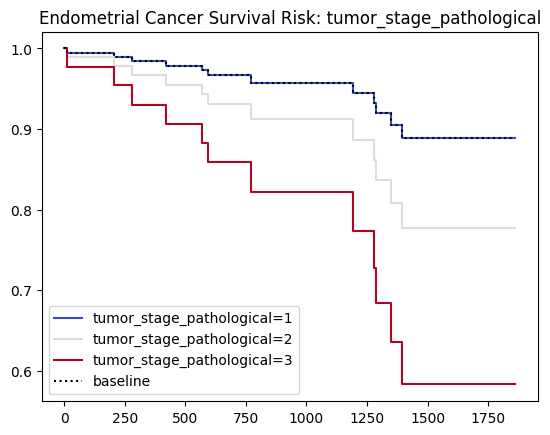

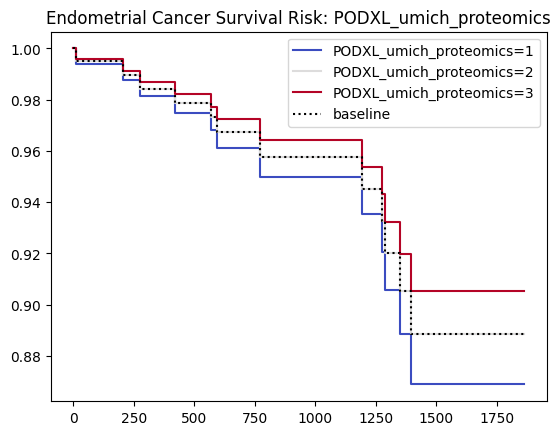

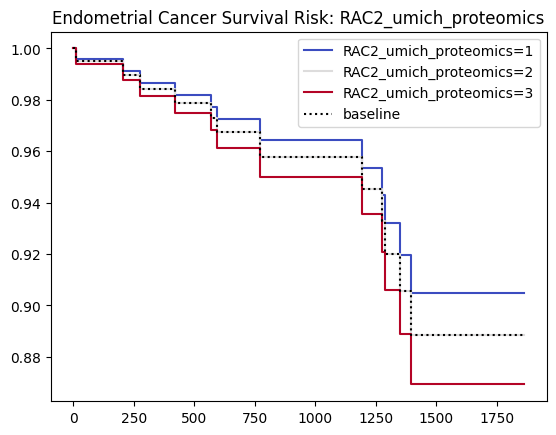

In [17]:
for attribute in attributes:
    plot_title = "Endometrial Cancer Survival Risk: " + attribute
    cph.plot_partial_effects_on_outcome(attribute, [1,2,3], cmap='coolwarm', 
                          title=plot_title)

# Results
These different analyses tend to follow the baseline survival function, however, there are some differences in varying levels of each attribute. For example, FIGO Stage I tumors tend to have a higher survival rate over time comparatively to Stage III tumors.  We can explore these differences with the CoxPHFitter object's *print_summary* function (which prints out results for multivariate linear regression).

In [18]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 103 total observations, 91 right-censored observations>
             duration col = 'Days_Until_Last_Contact_Or_Death'
                event col = 'Survival status (1, dead; 0, alive)'
      baseline estimation = breslow
   number of observations = 103
number of events observed = 12
   partial log-likelihood = -45.702
         time fit was run = 2023-09-13 20:43:11 UTC
                    model = untransformed variables

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
tumor_stage_pathological  0.759      2.136      0.274            0.222            1.295                1.249                3.652
RAC2_umich_proteomics     0.170      1.185      0.409           -0.632            0.971                0.531                2.641
PODXL_umich_proteomics   -0.173      0.841      0.416           -0.989            0.643                0.372                1.903

                           cmp to      z     p   -log2(p)
covariate                                                
tumor_stage_pathological    0.000  2.773 0.006      7.490
RAC2_umich_proteomics       0.000  0.415 0.678      0.560
PODXL_umich_proteomics      0.000 -0.415 0.678      0.560
---
Concordance = 0.754
Partial AIC = 97.403
log-likelihood ratio test = 8.276 on 3 df
-log2(p) of ll-ratio test = 4.621

# Step 6 Cox's Proportional Hazard Test
With the *proportional_hazard_test* function, we can now perform Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival.  This is shown by the hazard ratio in the column labeled *-log2(p)* below.  In general, a hazard ratio of 1 suggests that an attribute has no effect on overall survival.  A ratio less than 1 suggests that an attribute contributes to lower survival risk.  A ratio greater than 1 suggests that an attribute contributes to higher survival risk.

In [19]:
results = proportional_hazard_test(cph, df_clean, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 103 total observations, 91 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic    p  -log2(p)
PODXL_umich_proteomics              1.40 0.24      2.08
RAC2_umich_proteomics               0.31 0.58      0.79
tumor_stage_pathological            1.73 0.19      2.41

Below, we show confidence intervals for each of the hazard ratios.  Since both bars include the log(HR) of 1.0 and both of their p-values were greater than 0.05, there is insufficient evidence to suggest that a specific Histologic Grade or Tumor Stage is connected with negative clinical outcomes of death or the development of a new tumor *in our cohort of Endometrial cancer tumors*.

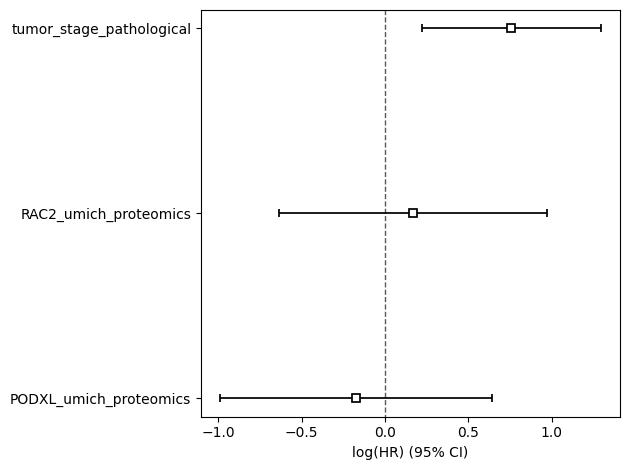

In [20]:
cph.plot()
plt.tight_layout()

# Closing Remarks
It is important to note that there are relatively few patients who died in our cohort (7 out of 88), which is good, but with such a small sample size of death events, it is difficult to conclude with certainty that these features are not more or less connected with survival.  Perhaps a sample of patients with more deaths might have different results.  Alternatively, studying an event with more negative outcomes (such as tumor recurrence) may also provide more data to work with.

In [21]:
df_clean['Survival status (1, dead; 0, alive)'].value_counts()

Survival status (1, dead; 0, alive)
False    91
True     12
Name: count, dtype: int64

It is also important to note that the confidence intervals for these ratios are very large, especially since hazard ratios are standardly shown on a log-scale.

In [22]:
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
covariate,,
tumor_stage_pathological,0.222404,1.295220
RAC2_umich_proteomics,-0.632089,0.971199
PODXL_umich_proteomics,-0.988706,0.643185


This is just one example of how you might use Survival Analysis to learn more about different types of cancer, and how clinical and/or genetic attributes contribute to likelihood of survival. There are many other clinical and genetic attributes, as well as several other cancer types, that can be explored using a similar process to that above. In particular, lung cancer and ovarian cancer have a larger number of negative outcomes per cohort, and would be good to look into further. 